In [104]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [105]:
import numpy as np
import pandas as pd

In [106]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [107]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [108]:
database_path = "/Users/monicachao/Desktop/DatascienceBootcamp/homework/sqlalchemy-challenge/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}", echo=False)


In [109]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [110]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [111]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [112]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [113]:
session.query(func.count(Measurement.date)).all()

earlieststr = session.query(Measurement.date).order_by(Measurement.date).first()
lateststr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earlieststr[0]} , Latest: {lateststr[0]}")


latestdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
print(querydate)

sel = [Measurement.date, Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

precipitation = pd.DataFrame(queryresult, columns = ["Date", "Precipitation"])
precipitation = precipitation.dropna(how='any')
precipitation = precipitation.sort_values(['Date'], ascending = True)
precipitation = precipitation.set_index("Date")
precipitation.head()


Earliest: 2010-01-01 , Latest: 2017-08-23
2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


![precipitation](Images/precipitation.png)

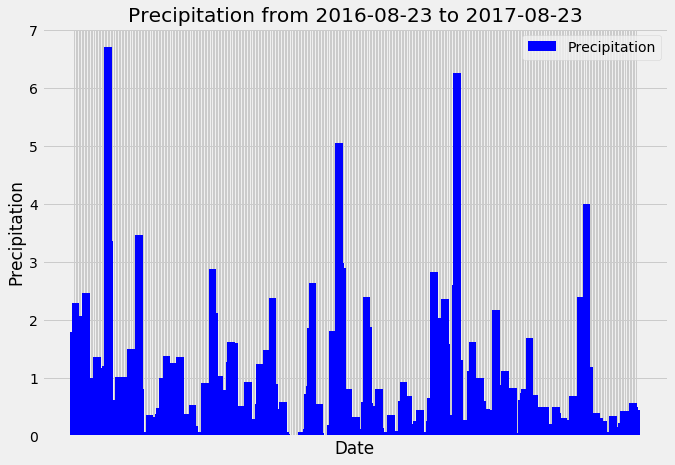

In [114]:
# Use Pandas to calcualte the summary statistics for the precipitation data

x = precipitation.index.tolist()
y = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(x,y, align = "center", label= "Precipitation", color='b', width = 5)
plt.title("Precipitation from 2016-08-23 to 2017-08-23")
plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.tick_params(
    axis='x',
    labelbottom=False
)

plt.legend()
plt.show()

![describe](Images/describe.png)

In [115]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [116]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [117]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
mostactive = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactive

(54.0, 85.0, 71.66378066378067)

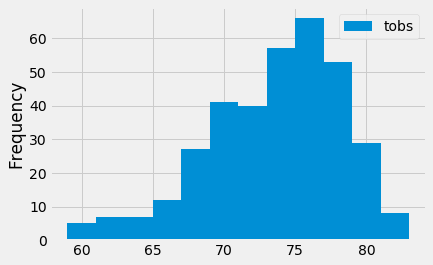

In [118]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == activestations[0][0]).\
    filter(Measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])

stationname = stations_desc.loc[stations_desc["Station"]==activestations[0][0],"Name"].tolist()[0]


plt.hist(temperatures, bins=12, label = 'tobs')
plt.grid(axis = 'both')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

![precipitation](Images/station-histogram.png)

In [119]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [120]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2017-07-23'
enddate = '2017-07-30'
tempresult = calc_temps(startdate,enddate)[0]
tempresult

(73.0, 79.08, 84.0)

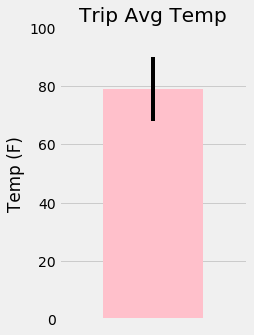

In [121]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = [0]
y = [tempresult[1]]
error = [(tempresult[2] - tempresult[0])]

plt.figure(figsize=(3, 5))
plt.bar(x,y,color='pink', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [122]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

startdate = '2017-07-23'
enddate = '2017-07-30'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
stations

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.24
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.56
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.37
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.92
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.05
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.05
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.01


## Optional Challenge Assignment